In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'/usr/spark/spark-2.4.5-bin-hadoop2.7'

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf=pyspark.SparkConf().setAppName('SparkApp').setMaster('local')
sc=pyspark.SparkContext(conf=conf)
spark=SparkSession(sc)
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [4]:
import numpy as np
from pyspark.ml.linalg import *
from pyspark.sql.types import * 
from pyspark.sql.functions import *
from pyspark.ml.feature import FeatureHasher
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
df = spark.read.format("csv").load("hdfs://localhost:9000/user/deepak/orders/")
prod_order = spark.read.format("csv").load("hdfs://localhost:9000/user/deepak/order_products_train/")
products = spark.read.format("csv").load("hdfs://localhost:9000/user/deepak/products/")

In [6]:
print("schema of orders table",df.schema.names)
print("schema of order_product_train table",prod_order.schema.names)
print("schema of products table",products.schema.names)

schema of orders table ['_c0', '_c1', '_c2', '_c3']
schema of order_product_train table ['_c0', '_c1']
schema of products table ['_c0', '_c1']


In [7]:
products=products.select(col("_c0").alias("product_id"), col("_c1").alias("product_name"))
prod_order=prod_order.select(col("_c0").alias("order_id"), col("_c1").alias("product_id"))
df = df.select(col("_c0").alias("order_id"), col("_c1").alias("user_id"),col("_c2").alias("order_number"),col("_c3").alias("days_since_prior_order"))

In [8]:
df.show()

+--------+-------+------------+----------------------+
|order_id|user_id|order_number|days_since_prior_order|
+--------+-------+------------+----------------------+
| 2539329|      1|           1|                   0.0|
| 2398795|      1|           2|                  15.0|
|  473747|      1|           3|                  21.0|
| 2254736|      1|           4|                  29.0|
|  431534|      1|           5|                  28.0|
| 3367565|      1|           6|                  19.0|
|  550135|      1|           7|                  20.0|
| 3108588|      1|           8|                  14.0|
| 2295261|      1|           9|                   0.0|
| 2550362|      1|          10|                  30.0|
| 1187899|      1|          11|                  14.0|
| 2168274|      2|           1|                   0.0|
| 1501582|      2|           2|                  10.0|
| 1901567|      2|           3|                   3.0|
|  738281|      2|           4|                   8.0|
| 1673511|

In [9]:
prod_order.show()

+--------+----------+
|order_id|product_id|
+--------+----------+
|       1|     49302|
|       1|     11109|
|       1|     10246|
|       1|     49683|
|       1|     43633|
|       1|     13176|
|       1|     47209|
|       1|     22035|
|      36|     39612|
|      36|     19660|
|      36|     49235|
|      36|     43086|
|      36|     46620|
|      36|     34497|
|      36|     48679|
|      36|     46979|
|      38|     11913|
|      38|     18159|
|      38|      4461|
|      38|     21616|
+--------+----------+
only showing top 20 rows



In [10]:
products.show()

+----------+--------------------+
|product_id|        product_name|
+----------+--------------------+
|         1|Chocolate Sandwic...|
|         2|    All-Seasons Salt|
|         3|Robust Golden Uns...|
|         4|Smart Ones Classi...|
|         5|Green Chile Anyti...|
|         6|        Dry Nose Oil|
|         7|Pure Coconut Wate...|
|         8|Cut Russet Potato...|
|         9|Light Strawberry ...|
|        10|Sparkling Orange ...|
|        11|   Peach Mango Juice|
|        12|Chocolate Fudge L...|
|        13|   Saline Nasal Mist|
|        14|Fresh Scent Dishw...|
|        15|Overnight Diapers...|
|        16|Mint Chocolate Fl...|
|        17|   Rendered Duck Fat|
|        18|Pizza for One Sup...|
|        19|Gluten Free Quino...|
|        20|Pomegranate Cranb...|
+----------+--------------------+
only showing top 20 rows



In [11]:
df = df.join(prod_order, "order_id")

In [12]:
df=df.na.drop()

In [13]:
df = df.dropDuplicates()

In [14]:
df.show()

+--------+-------+------------+----------------------+----------+
|order_id|user_id|order_number|days_since_prior_order|product_id|
+--------+-------+------------+----------------------+----------+
| 1005754| 147981|           4|                   5.0|     45210|
| 1005754| 147981|           4|                   5.0|     12914|
| 1005754| 147981|           4|                   5.0|     22366|
| 1005754| 147981|           4|                   5.0|      1940|
| 1005754| 147981|           4|                   5.0|     17224|
| 1005754| 147981|           4|                   5.0|     44514|
| 1005754| 147981|           4|                   5.0|     38371|
| 1005754| 147981|           4|                   5.0|     13603|
| 1005754| 147981|           4|                   5.0|     38511|
| 1005754| 147981|           4|                   5.0|     47000|
| 1005754| 147981|           4|                   5.0|      6218|
| 1005754| 147981|           4|                   5.0|     12817|
| 1015263|

In [15]:
columns_to_drop = ['order_number','order_id']

df = df.drop(*columns_to_drop)

In [16]:
df_filtered=df.selectExpr("cast(user_id as string) user_id","cast(days_since_prior_order as int) days_since_prior_order")

In [17]:
df2=df_filtered.filter(df_filtered.days_since_prior_order > 0)

In [18]:
from pyspark.sql.functions import mean, min, max, sum, datediff, to_date
from pyspark.sql import functions as s


In [19]:
rec = df2.groupBy('user_id').agg(mean('days_since_prior_order').alias('Next_Transaction'))
freq=df2.groupBy('user_id').agg(s.count('days_since_prior_order').alias('Frequency'))

customers = rec.join(freq, "user_id")

In [20]:
cols = ['Next_Transaction','Frequency']
customers.describe(cols).show()

+-------+------------------+------------------+
|summary|  Next_Transaction|         Frequency|
+-------+------------------+------------------+
|  count|            129083|            129083|
|   mean| 17.33067096364355|10.594524453258757|
| stddev|10.535917595128629| 7.933946159680307|
|    min|               1.0|                 1|
|    max|              30.0|                80|
+-------+------------------+------------------+



In [21]:
customers.show()

+-------+----------------+---------+
|user_id|Next_Transaction|Frequency|
+-------+----------------+---------+
| 100140|            28.0|       13|
| 100263|             7.0|        4|
| 100320|             4.0|        8|
| 100735|             7.0|       20|
| 100768|            25.0|        1|
|  10096|             9.0|       10|
| 100964|            23.0|        6|
| 101205|            30.0|       63|
| 101261|             1.0|        2|
| 102113|            11.0|       12|
| 102521|            26.0|       14|
| 102684|             5.0|       11|
| 102745|            30.0|        4|
| 102944|             7.0|       10|
| 102952|             8.0|        8|
| 103050|            18.0|       11|
| 103368|            30.0|        9|
|  10351|            21.0|       14|
| 103634|             6.0|       43|
| 104344|             9.0|       11|
+-------+----------------+---------+
only showing top 20 rows



In [22]:
pd_df = customers.toPandas()

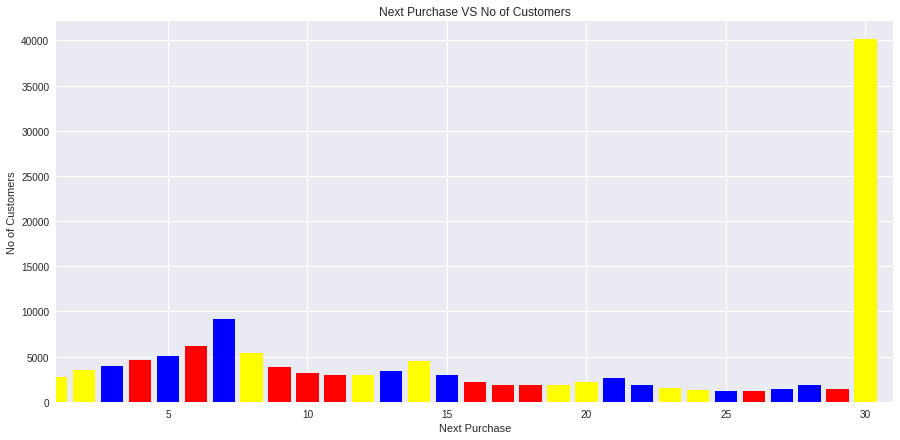

In [23]:
# Plotting the graph between Customers and their next puchase before filteration of the top customers
import matplotlib.pyplot as plt
import pandas as pd
#changing the type to int 
pd_df.Next_Transaction=pd_df.Next_Transaction.astype(int)
co = ["Yellow","Blue","Red"]

plt.style.use("seaborn")

fig, ax = plt.subplots(figsize = (15,7))

ax.bar(pd_df["Next_Transaction"].value_counts().index,
       pd_df["Next_Transaction"].value_counts(),color=co)

ax.set(title = "Next Purchase VS No of Customers",
       xlabel = "Next Purchase",
       ylabel = "No of Customers",
       xlim = (1,31))


plt.show()

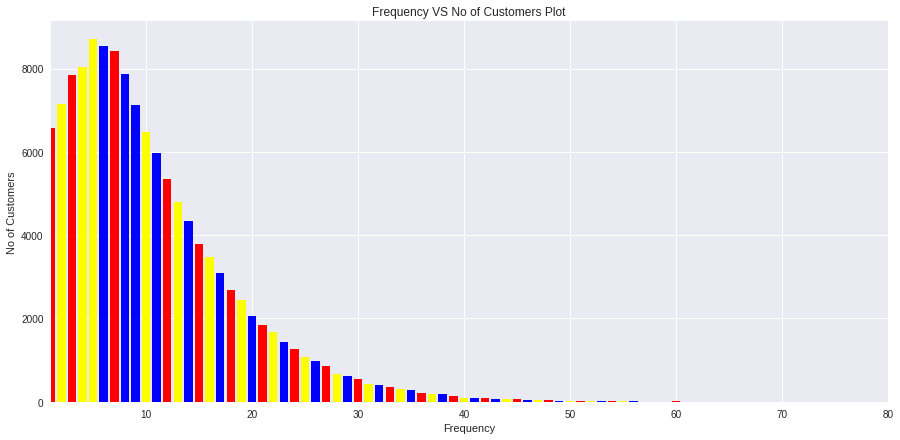

In [24]:
# Plotting the graph between Customers and their frequency before filteration of the top customers

co = ["Yellow","Blue","Red"]

plt.style.use("seaborn")

fig, ax = plt.subplots(figsize = (15,7))

ax.bar(pd_df["Frequency"].value_counts().index,
       pd_df["Frequency"].value_counts(),color=co)

ax.set(title = "Frequency VS No of Customers Plot",
       xlabel = "Frequency",
       ylabel = "No of Customers",
       xlim = (1,80))


plt.show()

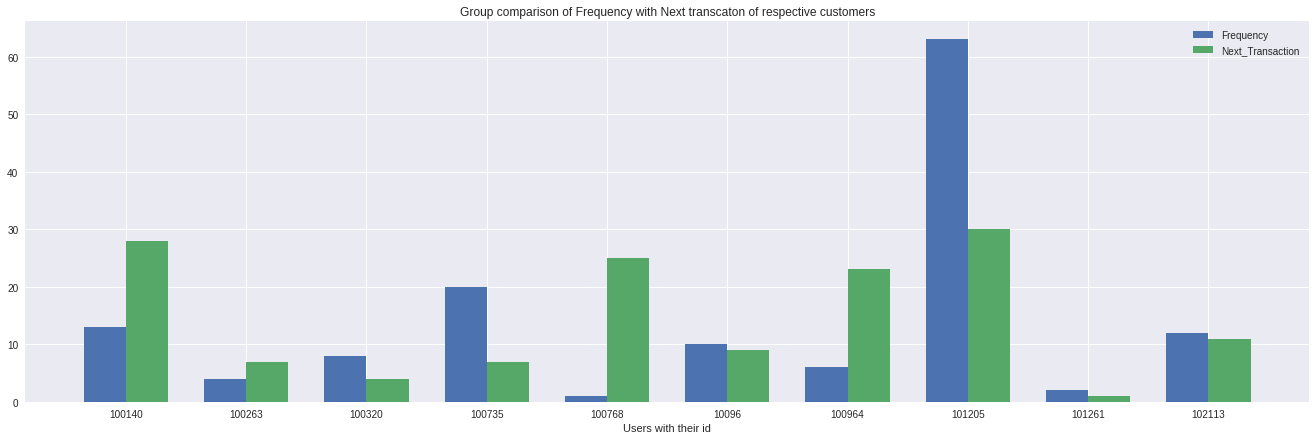

In [25]:
#Group comparison of Frequency with Next transcaton of respective customers before filteration
label=pd_df.user_id[:10]
plt.figure(figsize=(23,7))
plt.style.use("seaborn")
plt.bar(pd_df["user_id"].index[:10],pd_df["Frequency"][:10],label="Frequency",width=0.35)
plt.bar(pd_df["user_id"].index[:10] +0.35,pd_df["Next_Transaction"][:10],label="Next_Transaction",width=0.35)
plt.xticks(pd_df["user_id"].index[:10]+0.35/2,label)
plt.legend()
plt.xlabel("Users with their id")
plt.title("Group comparison of Frequency with Next transcaton of respective customers" )
plt.show()

In [26]:
customers.approxQuantile(cols,[0.25,0.5,0.75],0.0)

[[7.0, 15.0, 30.0], [5.0, 9.0, 14.0]]

In [27]:
def RScore(x):
    if  x <= 10:
        return 'L'
    elif x<= 15:
        return 'M'
    elif x<= 20:
        return 'AM'
    else:
        return 'H'

def FScore(x):
    if  x <= 5 :
        return 'L'
    elif x <= 9:
        return 'M'
    elif x <= 19:
        return 'AM'
    else:
        return 'H'


from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType

R_udf = udf(lambda x: RScore(x), StringType())
F_udf = udf(lambda x: FScore(x), StringType())


In [28]:
rf_seg = customers.withColumn("next_seg", R_udf("Next_Transaction"))

In [29]:
rf_seg = rf_seg.withColumn("freq_seg", F_udf("Frequency"))

In [30]:
rf_seg.show()

+-------+----------------+---------+--------+--------+
|user_id|Next_Transaction|Frequency|next_seg|freq_seg|
+-------+----------------+---------+--------+--------+
| 100140|            28.0|       13|       H|      AM|
| 100263|             7.0|        4|       L|       L|
| 100320|             4.0|        8|       L|       M|
| 100735|             7.0|       20|       L|       H|
| 100768|            25.0|        1|       H|       L|
|  10096|             9.0|       10|       L|      AM|
| 100964|            23.0|        6|       H|       M|
| 101205|            30.0|       63|       H|       H|
| 101261|             1.0|        2|       L|       L|
| 102113|            11.0|       12|       M|      AM|
| 102521|            26.0|       14|       H|      AM|
| 102684|             5.0|       11|       L|      AM|
| 102745|            30.0|        4|       H|       L|
| 102944|             7.0|       10|       L|      AM|
| 102952|             8.0|        8|       L|       M|
| 103050| 

In [31]:
rf_seg = rf_seg.withColumn('Ranking',s.concat(s.col('next_seg'),s.col('freq_seg')))

In [32]:
rf_seg.show()

+-------+----------------+---------+--------+--------+-------+
|user_id|Next_Transaction|Frequency|next_seg|freq_seg|Ranking|
+-------+----------------+---------+--------+--------+-------+
| 100140|            28.0|       13|       H|      AM|    HAM|
| 100263|             7.0|        4|       L|       L|     LL|
| 100320|             4.0|        8|       L|       M|     LM|
| 100735|             7.0|       20|       L|       H|     LH|
| 100768|            25.0|        1|       H|       L|     HL|
|  10096|             9.0|       10|       L|      AM|    LAM|
| 100964|            23.0|        6|       H|       M|     HM|
| 101205|            30.0|       63|       H|       H|     HH|
| 101261|             1.0|        2|       L|       L|     LL|
| 102113|            11.0|       12|       M|      AM|    MAM|
| 102521|            26.0|       14|       H|      AM|    HAM|
| 102684|             5.0|       11|       L|      AM|    LAM|
| 102745|            30.0|        4|       H|       L| 

In [33]:
top_customers=rf_seg.filter(rf_seg.Ranking =='LH')

In [34]:
top_customers.show()

+-------+----------------+---------+--------+--------+-------+
|user_id|Next_Transaction|Frequency|next_seg|freq_seg|Ranking|
+-------+----------------+---------+--------+--------+-------+
| 100735|             7.0|       20|       L|       H|     LH|
| 103634|             6.0|       43|       L|       H|     LH|
| 106022|             3.0|       26|       L|       H|     LH|
| 108791|             4.0|       20|       L|       H|     LH|
|  11888|             6.0|       26|       L|       H|     LH|
| 120478|             5.0|       36|       L|       H|     LH|
| 128357|             5.0|       20|       L|       H|     LH|
| 137217|             6.0|       31|       L|       H|     LH|
| 142039|             7.0|       33|       L|       H|     LH|
| 143037|             2.0|       26|       L|       H|     LH|
| 146433|             8.0|       24|       L|       H|     LH|
| 147754|             7.0|       29|       L|       H|     LH|
| 161622|             9.0|       20|       L|       H| 

In [35]:
columns_to_drop = ['next_seg','freq_seg','Ranking']

df = top_customers.drop(*columns_to_drop)

In [36]:
df.show()

+-------+----------------+---------+
|user_id|Next_Transaction|Frequency|
+-------+----------------+---------+
| 100735|             7.0|       20|
| 103634|             6.0|       43|
| 106022|             3.0|       26|
| 108791|             4.0|       20|
|  11888|             6.0|       26|
| 120478|             5.0|       36|
| 128357|             5.0|       20|
| 137217|             6.0|       31|
| 142039|             7.0|       33|
| 143037|             2.0|       26|
| 146433|             8.0|       24|
| 147754|             7.0|       29|
| 161622|             9.0|       20|
| 164558|            10.0|       25|
| 172857|             6.0|       22|
| 173567|             5.0|       23|
| 174116|             7.0|       26|
|  18130|             7.0|       26|
|  19338|             7.0|       26|
| 199457|             8.0|       22|
+-------+----------------+---------+
only showing top 20 rows



In [37]:
pd_df2 = top_customers.toPandas()

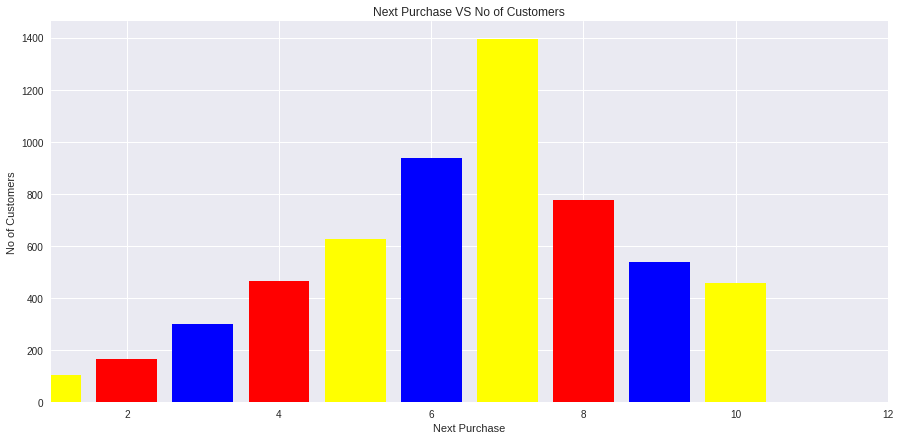

In [38]:
# Plotting the graph between Customers and their next puchase after filteration of the top customers
import matplotlib.pyplot as plt
import pandas as pd
#changing the type to int 
pd_df2.Next_Transaction=pd_df2.Next_Transaction.astype(int)
co = ["Yellow","Blue","Red"]

plt.style.use("seaborn")

fig, ax = plt.subplots(figsize = (15,7))

ax.bar(pd_df2["Next_Transaction"].value_counts().index,
       pd_df2["Next_Transaction"].value_counts(),color=co)

ax.set(title = "Next Purchase VS No of Customers",
       xlabel = "Next Purchase",
       ylabel = "No of Customers",
       xlim = (1,12))


plt.show()

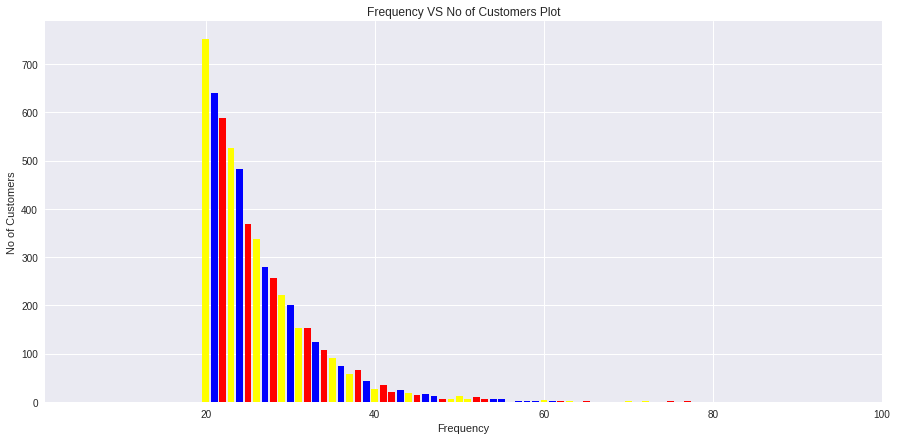

In [39]:
# Plotting the graph between Customers and their frequency after filteration of the top customers

co = ["Yellow","Blue","Red"]

plt.style.use("seaborn")

fig, ax = plt.subplots(figsize = (15,7))

ax.bar(pd_df2["Frequency"].value_counts().index,
       pd_df2["Frequency"].value_counts(),color=co)

ax.set(title = "Frequency VS No of Customers Plot",
       xlabel = "Frequency",
       ylabel = "No of Customers",
       xlim = (1,100))


plt.show()

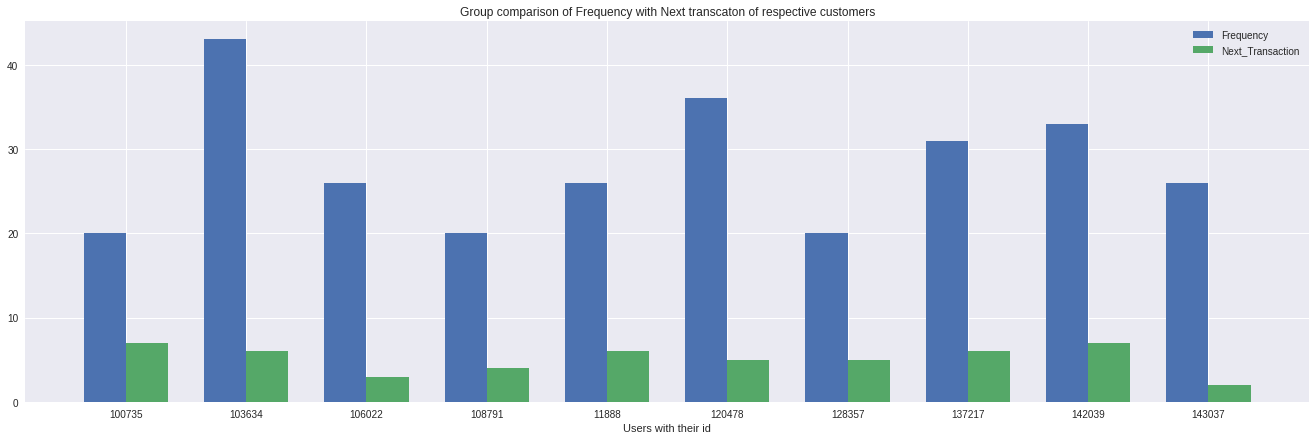

In [40]:
#Group comparison of Frequency with Next transcaton of respective customers before filteration
label=pd_df2.user_id[:10]
plt.figure(figsize=(23,7))
plt.style.use("seaborn")
plt.bar(pd_df2["user_id"].index[:10],pd_df2["Frequency"][:10],label="Frequency",width=0.35)
plt.bar(pd_df2["user_id"].index[:10] +0.35,pd_df2["Next_Transaction"][:10],label="Next_Transaction",width=0.35)
plt.xticks(pd_df2["user_id"].index[:10]+0.35/2,label)
plt.legend()
plt.xlabel("Users with their id")
plt.title("Group comparison of Frequency with Next transcaton of respective customers" )
plt.show()

In [41]:
orders =spark.read.format("csv").load("hdfs://localhost:9000/user/deepak/orders/")
orders = orders.select(col("_c0").alias("order_id"), col("_c1").alias("user_id"),col("_c2").alias("order_number"),col("_c3").alias("days_since_prior_order"))

In [42]:
train_data = sqlContext.createDataFrame(df.head(100), df.schema)

In [43]:
print((df.count(), len(df.columns)))

(5753, 3)


In [44]:
userorder = prod_order.join(orders, on = 'order_id', how = 'left_outer')

In [45]:
print((userorder.count(), len(userorder.columns)))

(1384617, 5)


In [46]:
topuserorders = train_data.join(userorder, on = 'user_id', how = 'left_outer')

In [47]:
topuserorders.show()

+-------+----------------+---------+--------+----------+------------+----------------------+
|user_id|Next_Transaction|Frequency|order_id|product_id|order_number|days_since_prior_order|
+-------+----------------+---------+--------+----------+------------+----------------------+
| 100735|             7.0|       20|  198492|     46820|           5|                   7.0|
| 100735|             7.0|       20|  198492|     13712|           5|                   7.0|
| 100735|             7.0|       20|  198492|     10292|           5|                   7.0|
| 100735|             7.0|       20|  198492|     32360|           5|                   7.0|
| 100735|             7.0|       20|  198492|     28902|           5|                   7.0|
| 100735|             7.0|       20|  198492|     34235|           5|                   7.0|
| 100735|             7.0|       20|  198492|     39276|           5|                   7.0|
| 100735|             7.0|       20|  198492|     38739|           5| 

In [48]:
cod = topuserorders.crosstab('user_id','product_id')

In [49]:
print((cod.count(), len(cod.columns)))

(100, 1652)


In [50]:
codp = cod.toPandas()
ind = codp['user_id_product_id']
codp.drop(['user_id_product_id'],axis=1,inplace = True)
similarity_mat = pd.DataFrame(cosine_similarity(codp), index = ind, columns = ind)
similarity_mat.head()

user_id_product_id,164558,63897,5023,164200,148958,143267,106022,114321,1903,147754,...,102970,87242,120478,98725,132204,40740,103634,18130,60351,146433
user_id_product_id,,,,,,,,,,,,,,,,,,,,,
164558,1.000000,0.000000,0.00000,0.071842,0.117670,0.030151,0.000000,0.044721,0.000000,0.000000,...,0.000000,0.044721,0.000000,0.034816,0.000000,0.0,0.030500,0.000000,0.000000,0.000000
63897,0.000000,1.000000,0.03745,0.064516,0.000000,0.054153,0.035223,0.000000,0.000000,0.033352,...,0.034565,0.000000,0.029934,0.000000,0.034565,0.0,0.082169,0.035223,0.039193,0.036662
5023,0.000000,0.037450,1.00000,0.000000,0.000000,0.031435,0.040893,0.000000,0.000000,0.000000,...,0.000000,0.093250,0.034752,0.000000,0.120386,0.0,0.095394,0.040893,0.091003,0.042563
164200,0.071842,0.064516,0.00000,1.000000,0.070447,0.054153,0.035223,0.040161,0.033942,0.000000,...,0.069130,0.080322,0.029934,0.000000,0.000000,0.0,0.054779,0.000000,0.039193,0.000000
148958,0.117670,0.000000,0.00000,0.070447,1.000000,0.000000,0.000000,0.043853,0.037062,0.000000,...,0.000000,0.043853,0.000000,0.000000,0.075485,0.0,0.029907,0.000000,0.000000,0.040032


In [51]:
top = topuserorders.toPandas()

In [52]:
prod = products.toPandas()

In [53]:
pro = prod.set_index('product_id')

In [54]:
def Recommender_System(user_id):
    l = []
    pro_count = top.groupby(['product_id','user_id']).size().sort_values(ascending=False).unstack().fillna(0)
    
    recommendations = pd.DataFrame(np.dot(pro_count.values,similarity_mat[str(user_id)]), index=pro_count.index,columns = ['score'])
    reco = recommendations.sort_values(by = 'score', ascending =False)
    re = reco.head(3)
    for i,score in re.iterrows():
        l.append(pro.iloc[int(i,10)]['product_name'])
    return l

In [55]:
Recommender_System(164558)

["Bag'N Season Pork Chops Seasoning Mix",
 'White Sugar Free Peppermint Gum',
 'Ginger Peach Black Bagged Tea']

In [56]:
td = train_data.toPandas()

In [57]:
td.head()

,user_id,Next_Transaction,Frequency
0,100735,7.0,20
1,103634,6.0,43
2,106022,3.0,26
3,108791,4.0,20
4,11888,6.0,26


In [58]:
top_cust = td.set_index('user_id')

In [59]:
top_cust.head()

,Next_Transaction,Frequency
user_id,,
100735,7.0,20
103634,6.0,43
106022,3.0,26
108791,4.0,20
11888,6.0,26


In [60]:
pro_rec ={}
for a,b in top_cust.iterrows():
    pro_rec[a] = Recommender_System(a)

In [61]:
from collections import OrderedDict
final_dict=OrderedDict(sorted(pro_rec.items()))

In [62]:
final=pd.DataFrame.from_dict(final_dict, orient='index',columns = ['Next_Best_offer','Second_Best_offer','Third_best_offer'])
final.index.name = 'user_id'

In [63]:
final.shape

(100, 3)

In [82]:
final.head(12)

,Next_Best_offer,Second_Best_offer,Third_best_offer
user_id,,,
100735,Egg Pasta Fettuccine,Red In Extra Light Syrup Grapefruit,Peach Rings Candy
100824,Fat Free Low Sodium Poppyseed Dressing,Bio Active Manuka Honey with Ginger,Salsa Ranch Yogurt Dressing
100953,Shredded 3 Cheese Italian,Fat Free Low Sodium Poppyseed Dressing,Warrior Blend Vanilla Dietary Supplement
102970,Gluten-Free Chipotle BBQ Black Bean Chips,Grilled Chicken Pesto with Vegetables Cafe Ste...,Fat Free Low Sodium Poppyseed Dressing
103634,Fat Free Low Sodium Poppyseed Dressing,Warrior Blend Vanilla Dietary Supplement,Shredded 3 Cheese Italian
106022,Fat Free Low Sodium Poppyseed Dressing,Bio Active Manuka Honey with Ginger,Warrior Blend Vanilla Dietary Supplement
108502,Warrior Blend Vanilla Dietary Supplement,Organic Rose Maqui & Cocao Bar,Gluten Free Quinoa Rotelle Pasta
108791,Shredded 3 Cheese Italian,Warrior Blend Vanilla Dietary Supplement,Earth Paste Amazingly Natural Toothpaste Peppe...
110084,Fat Free Low Sodium Poppyseed Dressing,Shredded 3 Cheese Italian,Salsa Ranch Yogurt Dressing
